In [1]:
%%capture
%cd .. 

# Introduction to some forms of parallelism

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path
data_dir = Path('data')

In [4]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool

## $\pi$ estimation exemple

Given a circle region $C$ of radius $R$, centred on origin, and arbitrary values $x, y \in [0, R]$,
$$
R^2 p((x, y) \in C) = \frac{\pi R^2}{4} \longrightarrow \pi = 4p((x, y) \in C),
$$
cosiderating
$$
p((x, y) \in C) = \lim_{N \to \infty} \frac{\sum_{i}^N g(\sqrt{x_i^2 + y_i^2})}{N},
$$
where
$$
g(r) = \left\{
    \begin{array}{rl}
        1, & r \le 1\\
        0, & r > 1
    \end{array}
\right..
$$

In [5]:
def N_in(N):
    points = np.random.random((N, 2)) # $[(x_1, y_1), (x_2, y_2), ...]$
    r = np.sqrt(np.sum(points**2, axis=1))
    return np.sum(r <= 1)

def approx_pi(N):
    return 4*N_in(N)/N

def timeit(function, *args, **kwargs):
    t0 = time.time()
    y = function(*args, **kwargs)
    tf = time.time()
    return tf - t0, y

def approx_pi_concurrent(N: int, n_workers: int) -> float:
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        output = executor.map(N_in, [int(N/n_workers)]*n_workers)
    return 4*np.sum(np.fromiter(output, int))/N

def approx_pi_multiprocess(N: int, n_workers: int) -> float:
    with Pool(n_workers) as pool:
        output = pool.map(N_in, [int(N/n_workers)]*n_workers)
    return 4*np.sum(np.fromiter(output, int))/N

In [6]:
delay, pi = timeit(approx_pi, int(1e8))
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 5.703751087188721 s
pi: 3.14157028


In [7]:
delay, pi = timeit(approx_pi_concurrent, int(1e8), 4)
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 1.9229884147644043 s
pi: 3.14138472


In [8]:
delay, pi = timeit(approx_pi_multiprocess, int(1e8), 4)
print(f'Tempo de execução: {delay} s\npi: {pi}')

Tempo de execução: 1.7925989627838135 s
pi: 3.14213088


In [11]:
%%time

w = 10
columns=('method', 'workers', 'N', 'delay', 'pi')
df = []
for N in np.linspace(1e5, 1e8, 10).astype(int):
    for _ in range(3):
        df.append(('sequential', 1, N, *timeit(approx_pi, N)))
        for workers in np.arange(1, w + 1):
            df.append(('threading', workers, N, *timeit(approx_pi_concurrent, N, workers)))
            df.append(('multiprocessing', workers, N, *timeit(approx_pi_multiprocess, N, workers)))
df = pd.DataFrame(df, columns=columns)
df['delay_per_point'] = df.delay/df.N
df.to_csv(data_dir/'approx_pi.csv')
df.head()

CPU times: user 9min 9s, sys: 1min 55s, total: 11min 5s
Wall time: 10min 48s


,method,workers,N,delay,pi,delay_per_point
0,sequential,1,100000,0.009212,3.14528,9.211540e-08
1,threading,1,100000,0.007979,3.14456,7.979393e-08
2,multiprocessing,1,100000,0.035071,3.14716,3.507066e-07
3,threading,2,100000,0.003895,3.14716,3.895044e-08
4,multiprocessing,2,100000,0.069990,3.13552,6.999016e-07


In [34]:
seq = df.method == 'sequential'
thr = df.method == 'threading'
mul = df.method == 'multiprocessing'

In [49]:
df[mul].groupby('workers').mean(numeric_only=True).shape

(10, 4)

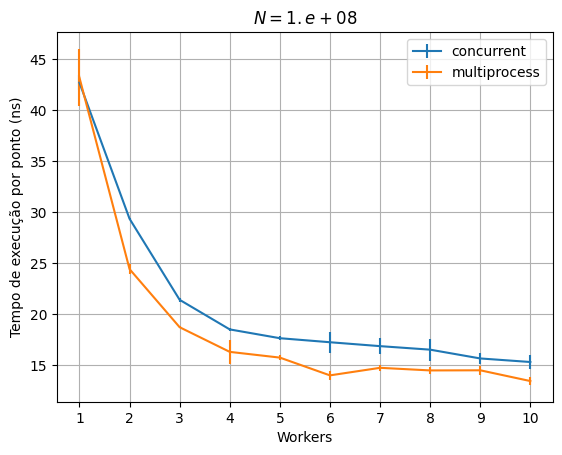

In [60]:
t = df.workers.unique()
loc = (df.N == df.N.max())
scale = 1e9
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.max(), 0)))
plt.show()

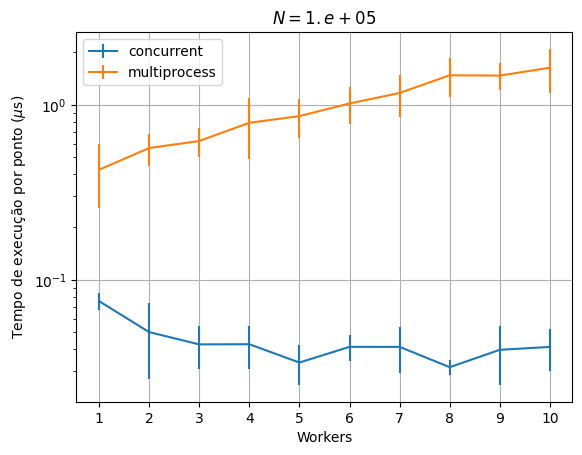

In [121]:
t = df.workers.unique()
loc = (df.N == df.N.min())
scale = 1e6
thr_group = df[thr & loc].groupby('workers')
mul_group = df[mul & loc].groupby('workers')
plt.errorbar(t, thr_group.mean(numeric_only=True).delay_per_point*scale, thr_group.std(numeric_only=True).delay_per_point*scale, label='concurrent')
plt.errorbar(t, mul_group.mean(numeric_only=True).delay_per_point*scale, mul_group.std(numeric_only=True).delay_per_point*scale, label='multiprocess')
plt.xticks(t)
plt.legend()
plt.grid()
plt.semilogy()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto ($\mu$s)')
plt.title(r'$N= {}$'.format(np.format_float_scientific(df.N.min(), 0)))
plt.show()

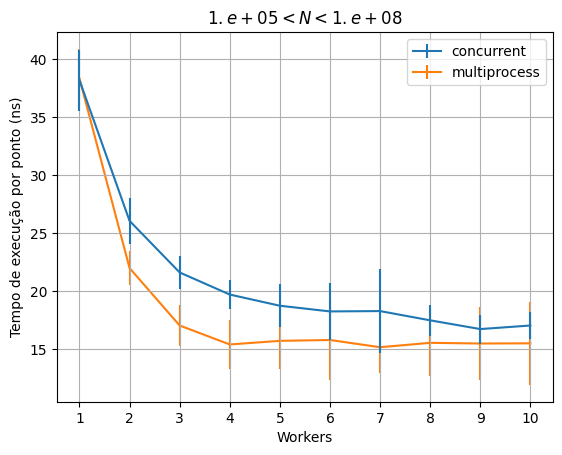

In [120]:
thr_vals = []
mul_vals = []
for N in df.N.unique()[1:-1]:
    loc = (df.N == N)
    thr_vals.append(np.stack(df[thr & loc].groupby('workers').agg(list)['delay_per_point'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('workers').agg(list)['delay_per_point'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)

scale = 1e9
t = df.workers.unique()
plt.errorbar(t, thr_vals.mean(axis=1)*scale, thr_vals.std(axis=1)*scale, label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1)*scale, mul_vals.std(axis=1)*scale, label='multiprocess', zorder=0)
# plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('Workers')
plt.ylabel(r'Tempo de execução por ponto (ns)')
plt.title(r'${} < N < {}$'.format(np.format_float_scientific(df.N.min(), 0), np.format_float_scientific(df.N.max(), 0)))
plt.show()

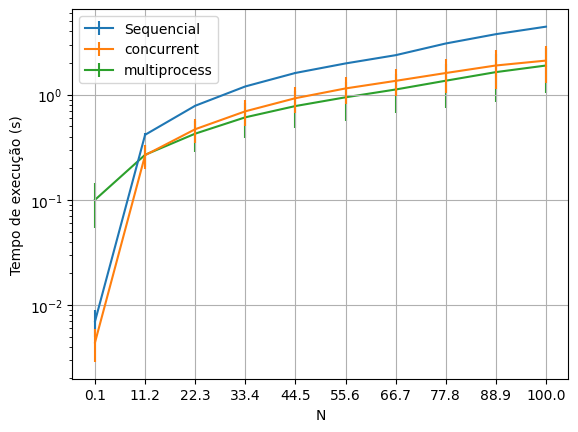

In [169]:
thr_vals = []
mul_vals = []
for workers in df.workers.unique():
    loc = (df.workers == workers)
    thr_vals.append(np.stack(df[thr & loc].groupby('N').agg(list)['delay'].values))
    mul_vals.append(np.stack(df[mul & loc].groupby('N').agg(list)['delay'].values))
thr_vals = np.concatenate(thr_vals, axis=1)
mul_vals = np.concatenate(mul_vals, axis=1)
seq_vals = np.stack(df[seq].groupby('N').agg(list)['delay'].values)

scale = 1e-6
t = df.N.unique()*scale
plt.errorbar(t, seq_vals.mean(axis=1), seq_vals.std(axis=1), label='Sequencial')
plt.errorbar(t, thr_vals.mean(axis=1), thr_vals.std(axis=1), label='concurrent')
plt.errorbar(t, mul_vals.mean(axis=1), mul_vals.std(axis=1), label='multiprocess', zorder=0)
plt.semilogy()
plt.xticks(t)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel(r'Tempo de execução (s)')
plt.show()

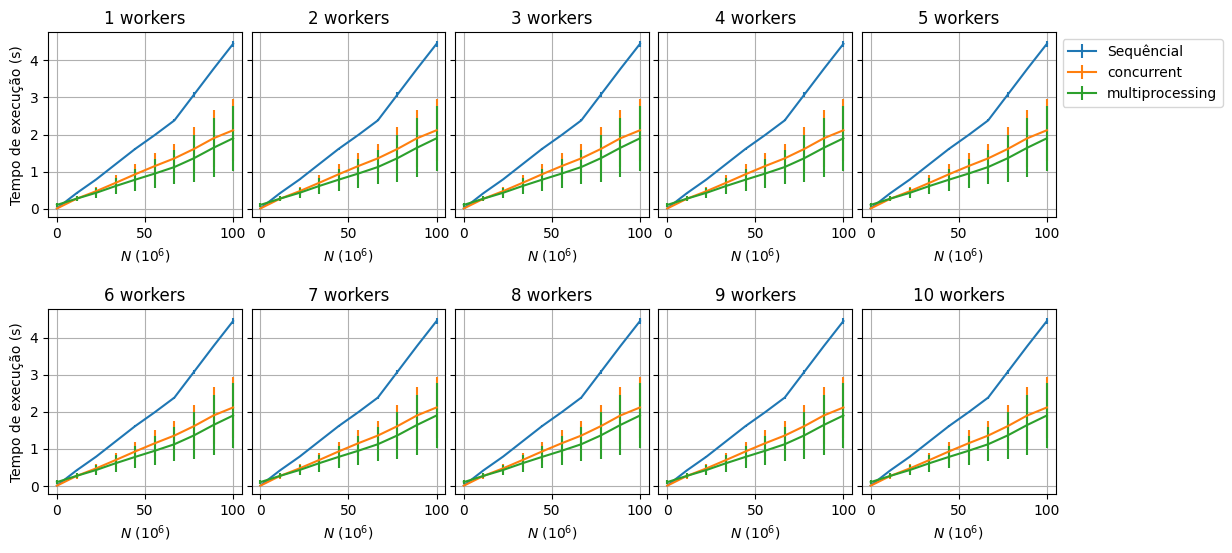

In [145]:
fig, axs = plt.subplots(2, 5, figsize=(13, 6), sharey=True)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5)

scale = 1e-6
for ax, w in zip(np.ravel(axs), df.workers.unique()):
    loc = df.workers == w
    seq_vals = df[seq].groupby('N')
    ax.errorbar(df.N.unique()*scale, seq_vals.mean(numeric_only=True).delay, seq_vals.std(numeric_only=True).delay, label='Sequencial')
    thr_vals = df[thr].groupby('N')
    ax.errorbar(df.N.unique()*scale, thr_vals.mean(numeric_only=True).delay, thr_vals.std(numeric_only=True).delay, label='concurrent')
    mul_vals = df[mul].groupby('N')
    ax.errorbar(df.N.unique()*scale, mul_vals.mean(numeric_only=True).delay, mul_vals.std(numeric_only=True).delay, label='multiprocessing')
    ax.grid()
    if ax == axs[0][4]: ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(f'{w} workers')
    ax.set_xlabel(r'$N$ ($10^6$)')

axs[0][0].set_ylabel('Tempo de execução (s)')
axs[1][0].set_ylabel('Tempo de execução (s)')

plt.show()
# plt.gca().set_aspect('equal')